In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import time, sys, os
import h5py
import numpy as np
import scipy
from matplotlib.pyplot import *

%matplotlib inline

# re-defining plotting defaults
from matplotlib.font_manager import FontProperties
from matplotlib import gridspec
rcParams.update({'xtick.major.pad': '7.0'})
rcParams.update({'xtick.major.size': '7.5'})
rcParams.update({'xtick.major.width': '1.5'})
rcParams.update({'xtick.minor.pad': '7.0'})
rcParams.update({'xtick.minor.size': '3.5'})
rcParams.update({'xtick.minor.width': '1.0'})
rcParams.update({'ytick.major.pad': '7.0'})
rcParams.update({'ytick.major.size': '7.5'})
rcParams.update({'ytick.major.width': '1.5'})
rcParams.update({'ytick.minor.pad': '7.0'})
rcParams.update({'ytick.minor.size': '3.5'})
rcParams.update({'ytick.minor.width': '1.0'})
rcParams.update({'xtick.color': 'k'})
rcParams.update({'ytick.color': 'k'})
rcParams.update({'font.size': 30})


In [3]:
# import os
# os.environ['SPS_HOME'] = '/home/mike/repos/fsps'

In [4]:
# import fsps
# import sedpy
# import prospect
# from prospect.likelihood import lnlike_spec, lnlike_phot, write_log
# from prospect.likelihood import chi_spec, chi_phot
# from prospect.models import priors
from prospect.fitting import lnprobfn
from prospect.fitting import fit_model
from prospect.io import write_results as writer
# import emcee
# import dynesty

import numpy as np
import pandas as pd
import corner

from agnfinder.prospector import demo_builders, cpz_builders, visualise, fitting
from agnfinder import columns


In [129]:
run_params = {}

# obs params
run_params["snr"] = 10.0

# model params
run_params["object_redshift"] = None
run_params["fixed_metallicity"] = None
run_params["add_duste"] = True
run_params['dust'] = True
run_params["zcontinuous"] = 1

run_params["verbose"] = False




In [6]:
DATA_ROOT='/media/mike/internal/agnfinder'
parquet_loc = os.path.join(DATA_ROOT, 'cpz_paper_sample.parquet')
df = pd.read_parquet(parquet_loc, columns=columns.cpz_cols['metadata'] + columns.cpz_cols['unified'])

In [7]:
galaxy = df.iloc[0]

In [8]:
obs = cpz_builders.build_cpz_obs(galaxy, snr=10.)

In [10]:
sps = demo_builders.build_sps(**run_params)

In [137]:
# --- start minimization ----
run_params["dynesty"] = False
run_params["emcee"] = False
run_params["optimize"] = True
run_params["min_method"] = 'lm'
# We'll start minimization from "nmin" separate places, 
# the first based on the current values of each parameter and the 
# rest drawn from the prior.  Starting from these extra draws 
# can guard against local minima, or problems caused by 
# starting at the edge of a prior (e.g. dust2=0.0)
run_params["nmin"] = 20


In [138]:
demo_model = demo_builders.build_model(**run_params)
model = cpz_builders.build_model_demo_style(**run_params)

In [141]:
if run_params['object_redshift'] is None:
    assert len(demo_model.initial_theta) < len(model.initial_theta)
else:
    assert all(demo_model.initial_theta == model.initial_theta)

In [142]:
model.initial_theta

array([ 0.0e+00,  1.0e+08, -5.0e-01,  5.0e-02,  1.3e+01,  1.0e+00])

In [143]:
demo_model.initial_theta

array([ 1.0e+08, -5.0e-01,  5.0e-02,  1.3e+01,  1.0e+00])

In [145]:
demo_output = fit_model(obs, demo_model, sps, lnprobfn=lnprobfn, **run_params)  # careful, modifies model in-place: model['optimization'], model['theta']
print("Done optimization in {}s".format(output["optimization"][1]))

Done optimization in 38.67586088180542s


In [146]:
output = fit_model(obs, model, sps, lnprobfn=lnprobfn, **run_params)  # careful, modifies model in-place: model['optimization'], model['theta']
print("Done optimization in {}s".format(output["optimization"][1]))

Done optimization in 177.60535550117493s


In [147]:
demo_model.theta

array([ 5.69458257e+06, -9.03345094e-01,  5.93157584e-01,  1.29883168e+00,
        1.60776081e-01])

In [148]:
model.theta

array([ 2.14796582e-01,  5.80766235e+06, -1.48103642e+00,  3.14565128e-01,
        2.30099279e+00,  3.93656025e-01])

Index of best result: 9
Best parameters: {'mass': 5694582.573108962, 'logzsol': -0.9033450944499191, 'dust2': 0.5931575837391768, 'tage': 1.2988316789377186, 'tau': 0.1607760807639902}


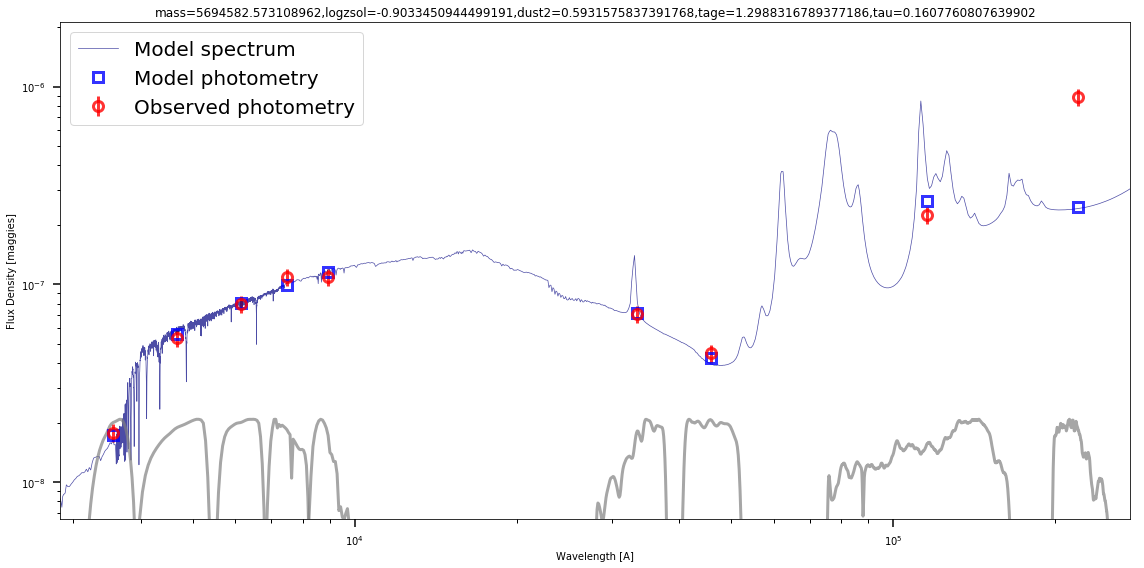

In [149]:
visualise.visualise_obs_and_model(obs, demo_model, fitting.get_best_theta(demo_model, demo_output), sps)

In [150]:
# theta_best = fitting.get_best_theta(model, output)
# # generate model using parameters identified as best, above
# prediction = model.mean_model(theta_best, obs=obs, sps=sps)
# pspec, pphot, pfrac = prediction

Index of best result: 3
Best parameters: {'zred': 0.2147965820722432, 'mass': 5807662.353794969, 'logzsol': -1.4810364176800797, 'dust2': 0.31456512819876825, 'tage': 2.300992794155854, 'tau': 0.39365602516572024}


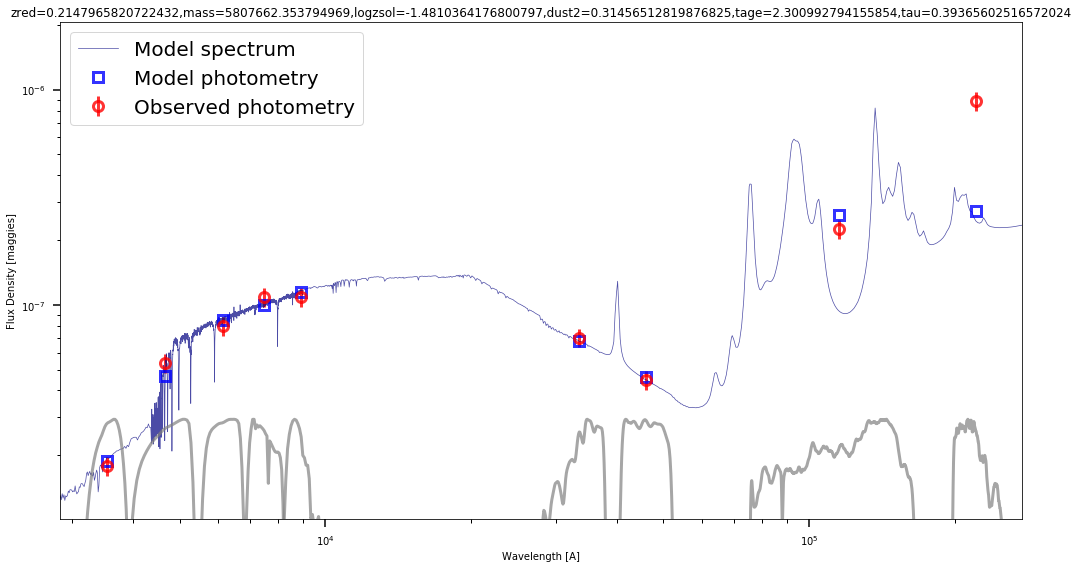

In [151]:
visualise.visualise_obs_and_model(obs, model, fitting.get_best_theta(model, output), sps)

In [161]:
# Set this to False if you don't want to do another optimization
# before emcee sampling (but note that the "optimization" entry 
# in the output dictionary will be (None, 0.) in this case)
# If set to true then another round of optmization will be performed 
# before sampling begins and the "optmization" entry of the output
# will be populated.
run_params["optimize"] = False
run_params["emcee"] = True
run_params["dynesty"] = False
# Number of emcee walkers
run_params["nwalkers"] = 128
# Number of iterations of the MCMC sampling
run_params["niter"] = 64  # was 512
# Number of iterations in each round of burn-in
# After each round, the walkers are reinitialized based on the 
# locations of the highest probablity half of the walkers.
run_params["nburn"] = [16, 32, 64]

In [162]:
output = fit_model(obs, model, sps, lnprobfn=lnprobfn, **run_params)
print('done emcee in {0}s'.format(output["sampling"][1]))

/media/mike/Windows/linux_cache/py36/lib/python3.6/site-packages/prospect-0.3.0-py3.6.egg/prospect/models/priors.py:104: RuntimeWarning: divide by zero encountered in log


done emcee in 186.58498454093933s


In [163]:
sampler = output['sampling'][0]

In [164]:
model.free_params

['zred', 'mass', 'logzsol', 'dust2', 'tage', 'tau']

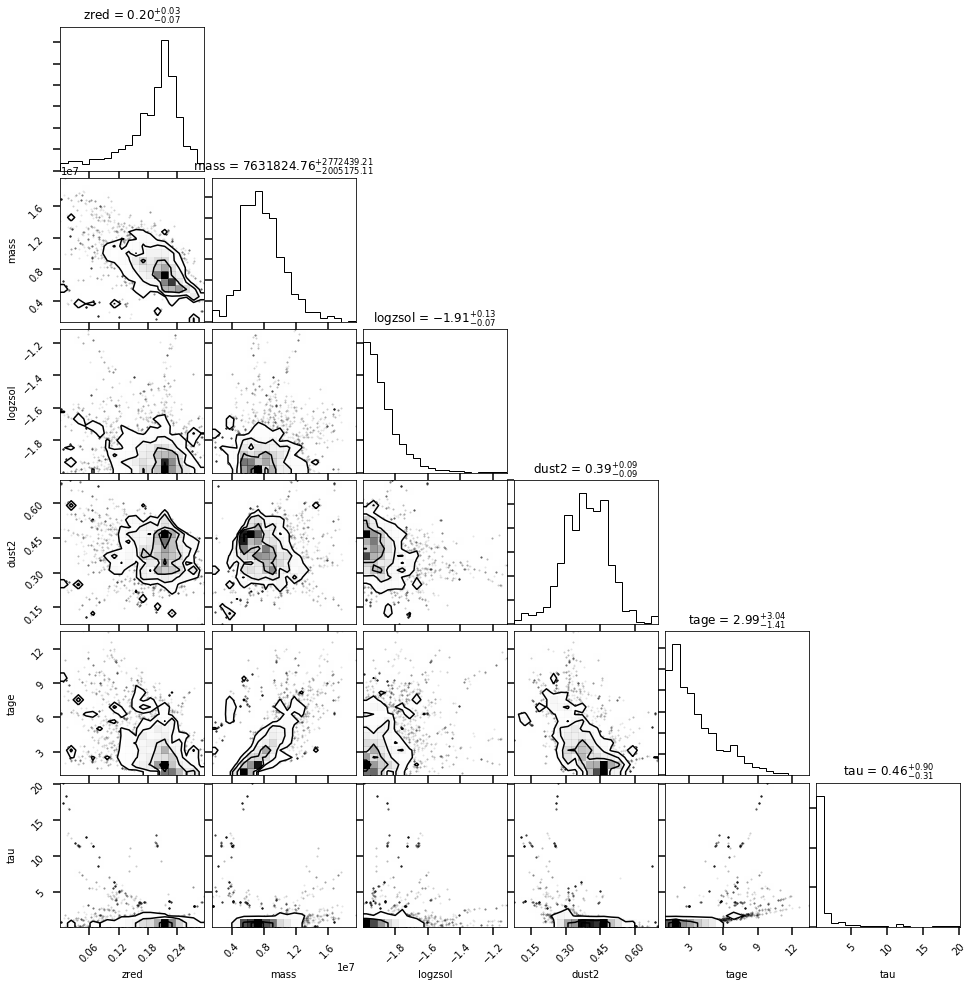

In [165]:

figure = corner.corner(sampler.flatchain, labels=model.free_params,
                       show_titles=True, title_kwargs={"fontsize": 12})

In [168]:
hfile = "demo_emcee_mcmc_v2.h5"
writer.write_hdf5(hfile, run_params, model, obs,
                  output["sampling"][0], output["optimization"][0],
                  tsample=output["sampling"][1],
                  toptimize=output["optimization"][1])

print('Finished')

Finished


## Nested Sampling via Multinest

In [152]:
run_params["dynesty"] = True
run_params["optmization"] = False
run_params["emcee"] = False
run_params["nested_method"] = "rwalk"
run_params["nlive_init"] = 400
run_params["nlive_batch"] = 200
run_params["nested_dlogz_init"] = 0.05
run_params["nested_posterior_thresh"] = 0.05
run_params["nested_maxcall"] = int(1e7)

In [153]:
output = fit_model(obs, model, sps, lnprobfn=lnprobfn, **run_params)
print('done dynesty in {0}s'.format(output["sampling"][1]))

iter: 5911 | batch: 7 | nc: 2 | ncall: 54747 | eff(%): 10.342 | loglstar: 123.618 < 131.188 < 131.121 | logz: 118.045 +/-  0.433 | stop:  1.000    

done dynesty in 849.4819712638855s


In [154]:
from prospect.io import write_results as writer
hfile = "demo_dynesty_mcmc.h5"
writer.write_hdf5(hfile, run_params, model, obs,
                  output["sampling"][0], output["optimization"][0],
                  tsample=output["sampling"][1],
                  toptimize=output["optimization"][1])

print('Finished')

Finished


/media/mike/Windows/linux_cache/py36/lib/python3.6/site-packages/prospect-0.3.0-py3.6.egg/prospect/io/write_results.py:60: RuntimeWarning: Could not store paramfile text
/media/mike/Windows/linux_cache/py36/lib/python3.6/site-packages/prospect-0.3.0-py3.6.egg/prospect/io/write_results.py:237: RuntimeWarning: Could not JSON serialize model_params, pickled instead


In [155]:
sampler = output["sampling"][0]

In [158]:
sampler.samples

array([[ 1.08131172e-01,  4.03543142e+09, -7.27562864e-01,
         8.47992443e-02,  6.10420384e-01,  7.69931230e+00],
       [ 2.92559414e-01,  1.35711626e+09, -4.95864881e-01,
         8.30347221e-01,  4.40613373e-01,  1.76946474e+00],
       [ 2.80232660e-01,  2.84245772e+08, -6.80364197e-01,
         6.41421530e-01,  1.11060224e-01,  3.22920618e-01],
       ...,
       [ 2.25954928e-01,  6.29357821e+06, -1.88012283e+00,
         3.86600542e-01,  2.01124755e+00,  2.82983059e-01],
       [ 2.26531975e-01,  6.25569359e+06, -1.89222062e+00,
         3.94552034e-01,  1.93545172e+00,  2.64325965e-01],
       [ 2.27697445e-01,  6.04199482e+06, -1.83393023e+00,
         3.78712524e-01,  1.94047175e+00,  2.77033705e-01]])

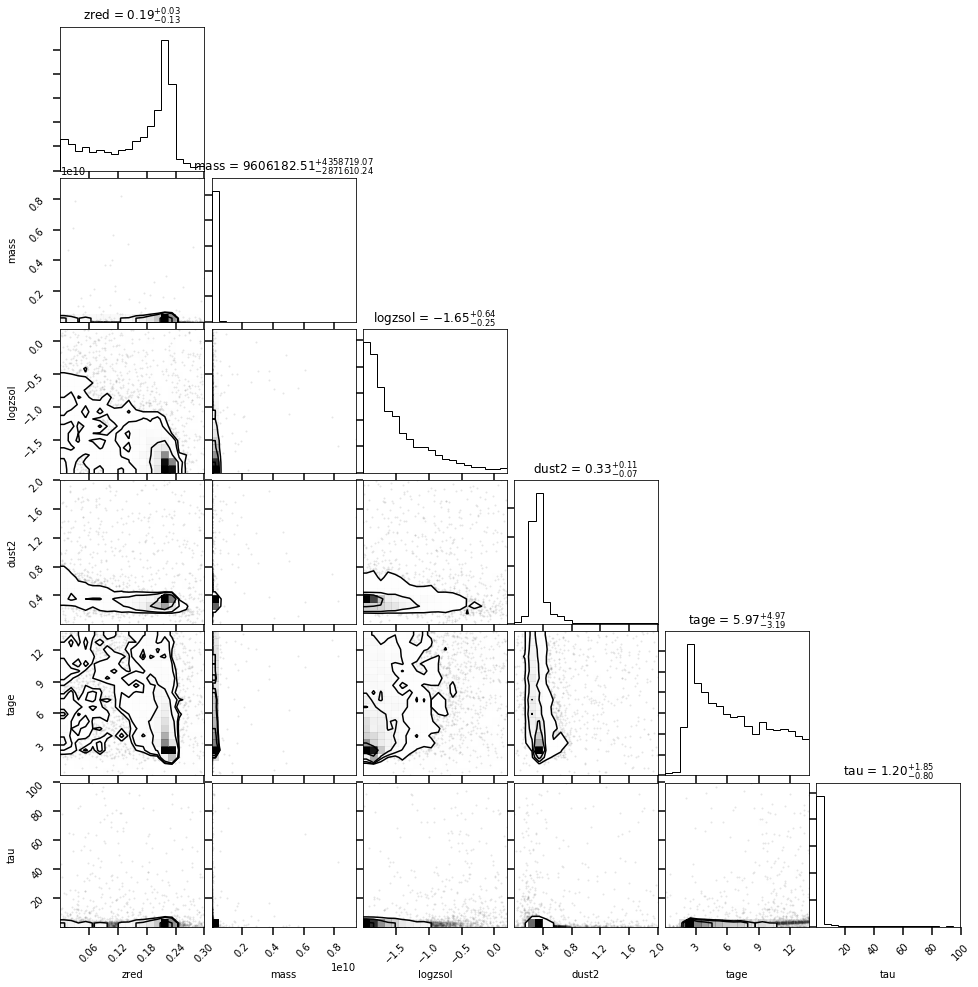

In [160]:

figure = corner.corner(sampler.samples, labels=model.free_params,
                       show_titles=True, title_kwargs={"fontsize": 12})

In [ ]:
# pedagogical custom log likelihood
# def lnprobfn(theta, model=None, obs=None, sps=None, 
#              nested=False, verbose=False):
#     """
#     Given a parameter vector, a model, a dictionary of observational 
#     data, and an sps object, return the ln of the posterior. 
#     """

#     # Calculate prior probability and exit if not within prior
#     # Also if doing nested sampling, do not include the basic priors, 
#     # since the drawing method includes the prior probability
#     lnp_prior = model.prior_product(theta, nested=nested)
#     if not np.isfinite(lnp_prior):
#         return -np.infty
        
#     # Generate "mean" model
#     spec, phot, mfrac = model.mean_model(theta, obs, sps=sps)
 
#     # Calculate likelihoods
#     lnp_spec = lnlike_spec(spec, obs=obs)
#     lnp_phot = lnlike_phot(phot, obs=obs)

#     return lnp_prior + lnp_phot + lnp_spec

In [ ]:
# def chivecfn(theta):
#     """A version of lnprobfn that returns the simple uncertainty 
#     normalized residual instead of the log-posterior, for use with 
#     least-squares optimization methods like Levenburg-Marquardt.
    
#     It's important to note that the returned chi vector does not 
#     include the prior probability.
#     """
#     lnp_prior = model.prior_product(theta)
#     if not np.isfinite(lnp_prior):
#         return np.zeros(model.ndim) - np.infty

#     # Generate mean model
#     try:
#         spec, phot, x = model.mean_model(theta, obs, sps=sps)
#     except(ValueError):
#         return np.zeros(model.ndim) - np.infty

#     chispec = chi_spec(spec, obs)
#     chiphot = chi_phot(phot, obs)
#     return np.concatenate([chispec, chiphot])

In [ ]:
# Generate the model SED at the initial value of theta
# theta = model.theta.copy()
# initial_spec, initial_phot, initial_mfrac = model.sed(theta, obs=obs, sps=sps)

In [ ]:
# how to define a custom parameter
mass_param = {"name": "mass",
              # The mass parameter here is a scalar, so it has N=1
              "N": 1,
              # We will be fitting for the mass, so it is a free parameter
              "isfree": True,
              # This is the initial value. For fixed parameters this is the
              # value that will always be used. 
              "init": 1e8,
              # This sets the prior probability for the parameter
              "prior": priors.LogUniform(mini=1e6, maxi=1e12),
              # this sets the initial dispersion to use when generating 
              # clouds of emcee "walkers".  It is not required, but can be very helpful.
              "init_disp": 1e6, 
              # this sets the minimum dispersion to use when generating 
              #clouds of emcee "walkers".  It is not required, but can be useful if 
              # burn-in rounds leave the walker distribution too narrow for some reason.
              "disp_floor": 1e6, 
              # This is not required, but can be helpful
              "units": "solar masses formed",
              }


In [ ]:
# how to show prebuilt models
TemplateLibrary.describe("parametric_sfh")